In [1]:
import re

from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

import sys
import nltk
import numpy as np
import pandas as pd
import pickle

# from helpers import *
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler 
# from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import metrics
import os
from matplotlib import pyplot as plt
sys.path.append(".")
sys.path.append("..")

lemmatizer = WordNetLemmatizer() 
# sb = SnowballStemmer('english')
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'us',
              'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
              'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
              'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
              'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
              'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
              'from', 'again', 'further', 'then', 'might', 'must', 'need', 'shall', 'once',
              'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few',
              'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than',
              'too', 'very', 's', 't', 'can', 'will', 'just', 'should', "should've", 'now',
              'd', 'll', 'm', 'o', 're', 've', 'y', 'ain']

### Read Data

In [2]:
dfTickets = pd.read_csv("all_tickets.csv",dtype=str)
# print(data[['title']])
print(dfTickets['title'])
# tickets_title = data[['title']]
# tickets_body = data[['body']]
# category = data[['category']]
# business_service = data[['business_service']]
# urgency = data[['urgency']]
# impact = data[['impact']]
# priority = data[['priority']]

0                                      service unavailable
1                                       for us not working
2                                           not responding
3                                   performance issues and
4                                 connection down th floor
5                                             inaccessible
6                              urgent cannot open files on
7                                    wireless network down
8                                           not accessible
9                                      certificate expired
10                              oracle errors when logging
11                                   oracle system is down
12         survey taking errors app outage for us accounts
13                     status resolved intermittent issues
14                                      the server is down
15                                      is not starting up
16                                       is not accessib

### Tokenize + Lemmatize Data + Stopwords Removal

#### Title Data

print("title length:",len(tickets_title))
preprocessed_title = []
for i in range(0,43106):
    lemmatized = []
    word = tickets_title.loc[i,'title'].lower()
    tokenizeWord = word_tokenize(word)
    filtered_sentence = [w for w in tokenizeWord if not w in stop_words]
    filtered_sentence = []
    for w in tokenizeWord: 
        if w not in stop_words: 
            filtered_sentence.append(w)         

    for word in filtered_sentence:
        lemmatized.append(lemmatizer.lemmatize(word))
        
    preprocessed_title.append(lemmatized)    

print(preprocessed_title[1])

#### Body Data

print("body length:",len(tickets_body))
preprocessed_body = []
for i in range(0,43106):
    lemmatized = []
    word = tickets_body.loc[i,'body'].lower()
    tokenizeWord = word_tokenize(word)
    filtered_sentence = [w for w in tokenizeWord if not w in stop_words]
    filtered_sentence = []
    for w in tokenizeWord: 
        if w not in stop_words: 
            filtered_sentence.append(w)         

    for word in filtered_sentence:
        lemmatized.append(lemmatizer.lemmatize(word))
        
    preprocessed_body.append(lemmatized)   

print(preprocessed_body[1])

# Split Data

In [19]:
column_to_predict = "urgency"
text_columns = "title"
data = dfTickets[text_columns]
labelData = dfTickets[column_to_predict]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2
)

In [20]:
print(train_data)

41482                              testing services vendor
24733                            change of project manager
41160                                           leaver for
4186                              frozen task notification
19122                                        po monitor hp
41779                               new quarantine account
8146                                                issues
33904                                access to and servers
18761                                             build en
21122                  new starter din hardware allocation
23077                                              hookers
25518                                          new starter
2420                                  can access one drive
27160                                    access to folders
23665                                             engagers
16443                           allocation new purchase po
17439                    equipment receiving from suppli

In [21]:
train_data.columns = ["test"]

In [22]:
print(train_data)

41482                              testing services vendor
24733                            change of project manager
41160                                           leaver for
4186                              frozen task notification
19122                                        po monitor hp
41779                               new quarantine account
8146                                                issues
33904                                access to and servers
18761                                             build en
21122                  new starter din hardware allocation
23077                                              hookers
25518                                          new starter
2420                                  can access one drive
27160                                    access to folders
23665                                             engagers
16443                           allocation new purchase po
17439                    equipment receiving from suppli

# Feature Set Extraction

#### Title / Urgency Feature

In [4]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [5]:
count_vect = StemmedCountVectorizer(stop_words="english")
vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(34485, 2433)

In [6]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(34485, 2433)

In [7]:
text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=True))
    ])
text_clf = text_clf.fit(train_data, train_labels)

In [8]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

# # Score and evaluate model on test data using model WITH hyperparameter tuning
# if use_grid_search:
#     predicted = gs_clf.predict(test_data)
#     prediction_acc = np.mean(predicted == test_labels)
#     print("Confusion matrix with GridSearch:")
#     print(metrics.confusion_matrix(test_labels, predicted))
#     print("Mean with GridSearch: " + str(prediction_acc))

Evaluating model
Confusion matrix without GridSearch:
[[ 437   55  610]
 [ 288  131  581]
 [ 149   39 6332]]
Mean without GridSearch: 0.8002783576896312


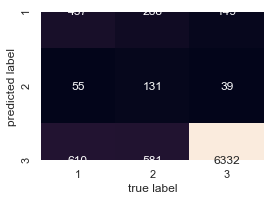

In [9]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
plt.show()

In [10]:
%matplotlib inline
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted,
                            target_names=np.unique(test_labels)))

              precision    recall  f1-score   support

           1       0.50      0.40      0.44      1102
           2       0.58      0.13      0.21      1000
           3       0.84      0.97      0.90      6520

    accuracy                           0.80      8622
   macro avg       0.64      0.50      0.52      8622
weighted avg       0.77      0.80      0.76      8622

